### Create pCO2 and CO2 Flux files from error reconstructions
### Climatology of Corrections used to fill prior to 1982

In [6]:
# =========================================
# For accessing directories
# =========================================
root_dir = "/data/artemis/workspace/vbennington/LDEO_HPD/models/XGB/GCB_2021"  # directory output will be written to  
data_output_dir = f"/data/artemis/workspace/vbennington/LDEO_HPD/data"  # directory with features and pCO2
recon_output_dir = f"{root_dir}/reconstructions" # reconstructions saved here

In [2]:
# standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import joblib
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
%config InlineBackend.print_figure_kwargs = {'dpi':300, 'bbox_inches': 'tight'}
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator

In [3]:
#models = [ 'cesm_spco2_1x1_A','csiro_spco2_1x1_A','fesom_spco2_1x1_A','mpi_spco2_1x1_A','cnrm_spco2_1x1_A','ipsl_spco2_1x1_A',
#          'planktom_spco2_1x1_A','noresm_spco2_1x1_A','princeton_spco2_1x1_A']

models = [ 'cesm_sfco2_1x1_A','fesom2_sfco2_1x1_A','mpi_sfco2_1x1_A','cnrm_sfco2_1x1_A','ipsl_sfco2_1x1_A',
          'planktom_sfco2_1x1_A','noresm_sfco2_1x1_A','princeton_sfco2_1x1_A']

In [7]:
test = xr.load_dataset(f"{recon_output_dir}/{models[0]}_recon_198201-202012.nc")

In [8]:
print(test)

<xarray.Dataset>
Dimensions:                 (time: 468, xlon: 360, ylat: 180)
Coordinates:
  * time                    (time) datetime64[ns] 1982-01-15 ... 2020-12-15
  * xlon                    (xlon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * ylat                    (ylat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Data variables:
    net_mask                (time, xlon, ylat) float32 nan nan nan ... nan nan
    socat_mask              (time, xlon, ylat) float64 nan nan nan ... nan nan
    pCO2                    (time, xlon, ylat) float64 nan nan nan ... nan nan
    cesm_sfco2_1x1_A        (time, xlon, ylat) float64 nan nan ... 386.7 387.4
    error_cesm_sfco2_1x1_A  (time, xlon, ylat) float64 nan nan nan ... nan nan


In [9]:
%run ../_Val_Mapping.ipynb

In [10]:
test = test.rename({"ylat":"lat","xlon":"lon"})

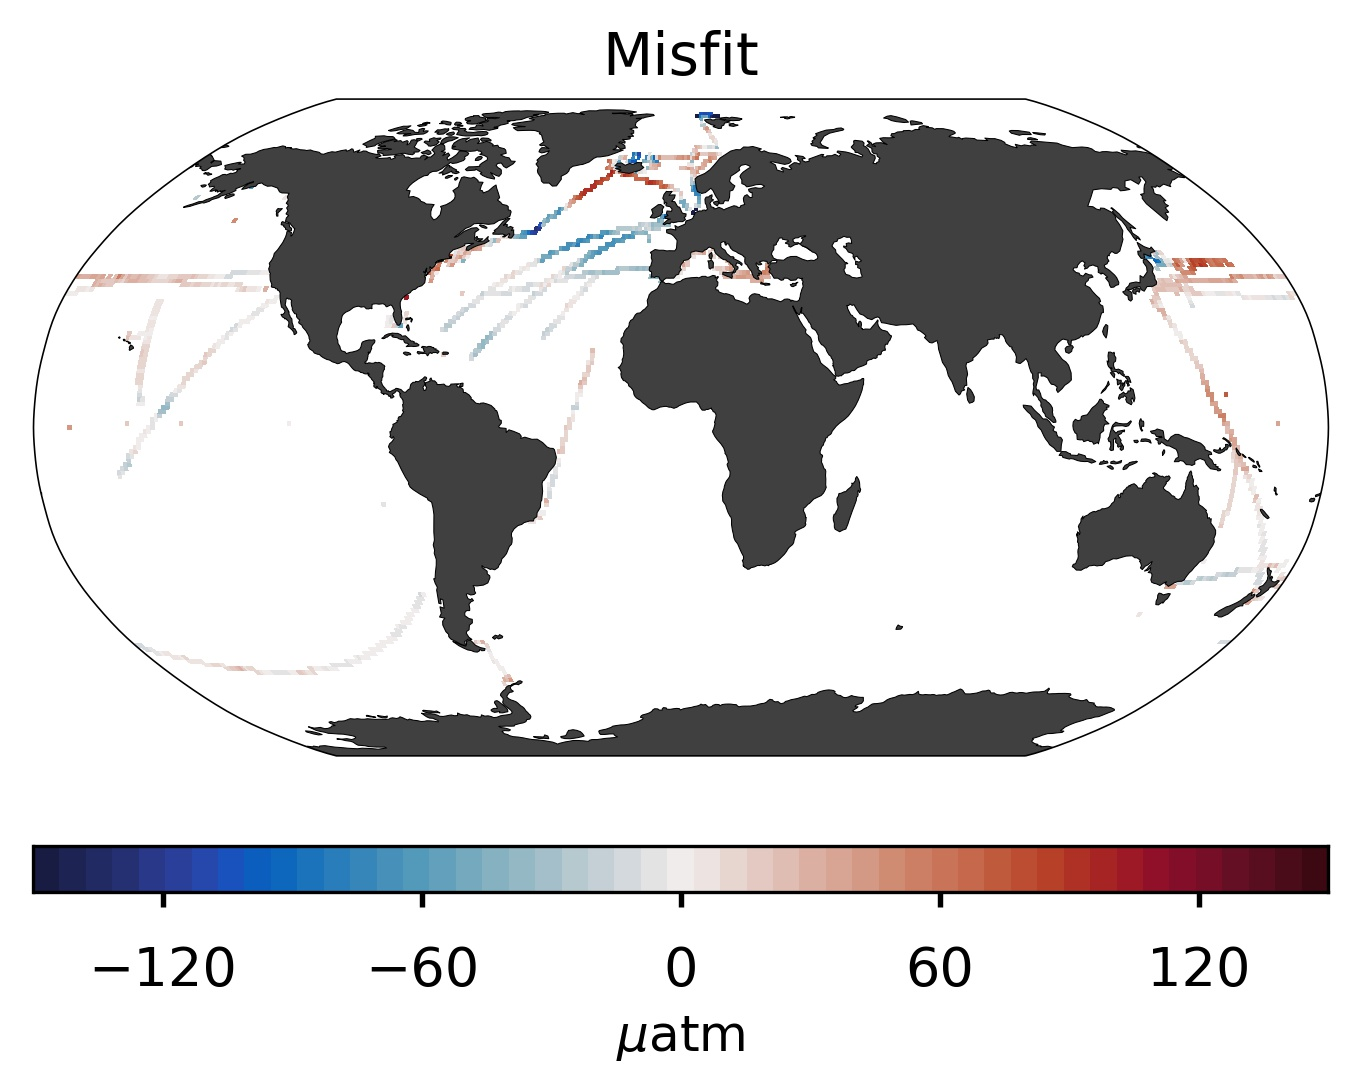

In [12]:
region='world'
cmap = cm.cm.balance
plot_style = 'seaborn-talk'

fig = plt.figure(figsize=(6,3.5))
fig_shape=(1,1)
vrange = [-150, 150, 50]
    
with plt.style.context(plot_style):
    dia = SpatialMap2(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    data2 = test[f'pCO2'][400,:,:].transpose() - test[f'cesm_sfco2_1x1_A'][400,:,:].transpose()
    sub=dia.add_plot(lat=test.lat,lon=test.lon,data=data2, vrange=vrange[0:3], cmap=cmap,ax=0)
    dia.set_title("Misfit",0,fontsize=14)
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col,f"$\mu$atm",fontsize=12)
plt.show()

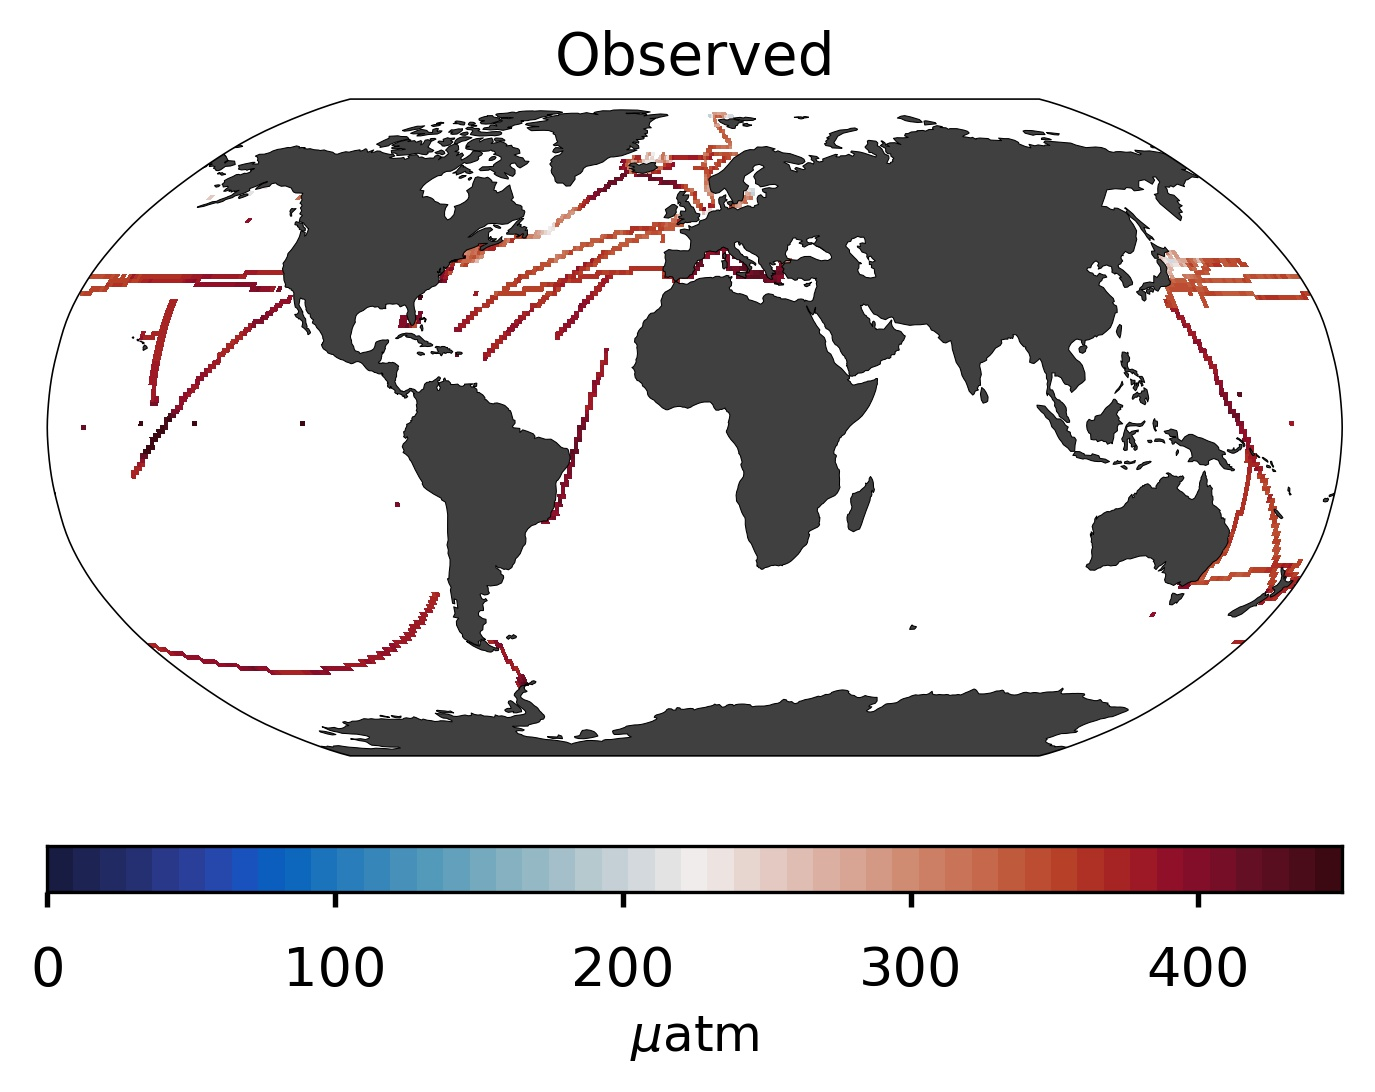

In [13]:
region='world'
cmap = cm.cm.balance
plot_style = 'seaborn-talk'

fig = plt.figure(figsize=(6,3.5))
fig_shape=(1,1)
vrange = [0, 450, 50]
    
with plt.style.context(plot_style):
    dia = SpatialMap2(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    data2 = test[f'pCO2'][400,:,:].transpose()
    sub=dia.add_plot(lat=test.lat,lon=test.lon,data=data2, vrange=vrange[0:3], cmap=cmap,ax=0)
    dia.set_title("Observed",0,fontsize=14)
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col,f"$\mu$atm",fontsize=12)
plt.show()

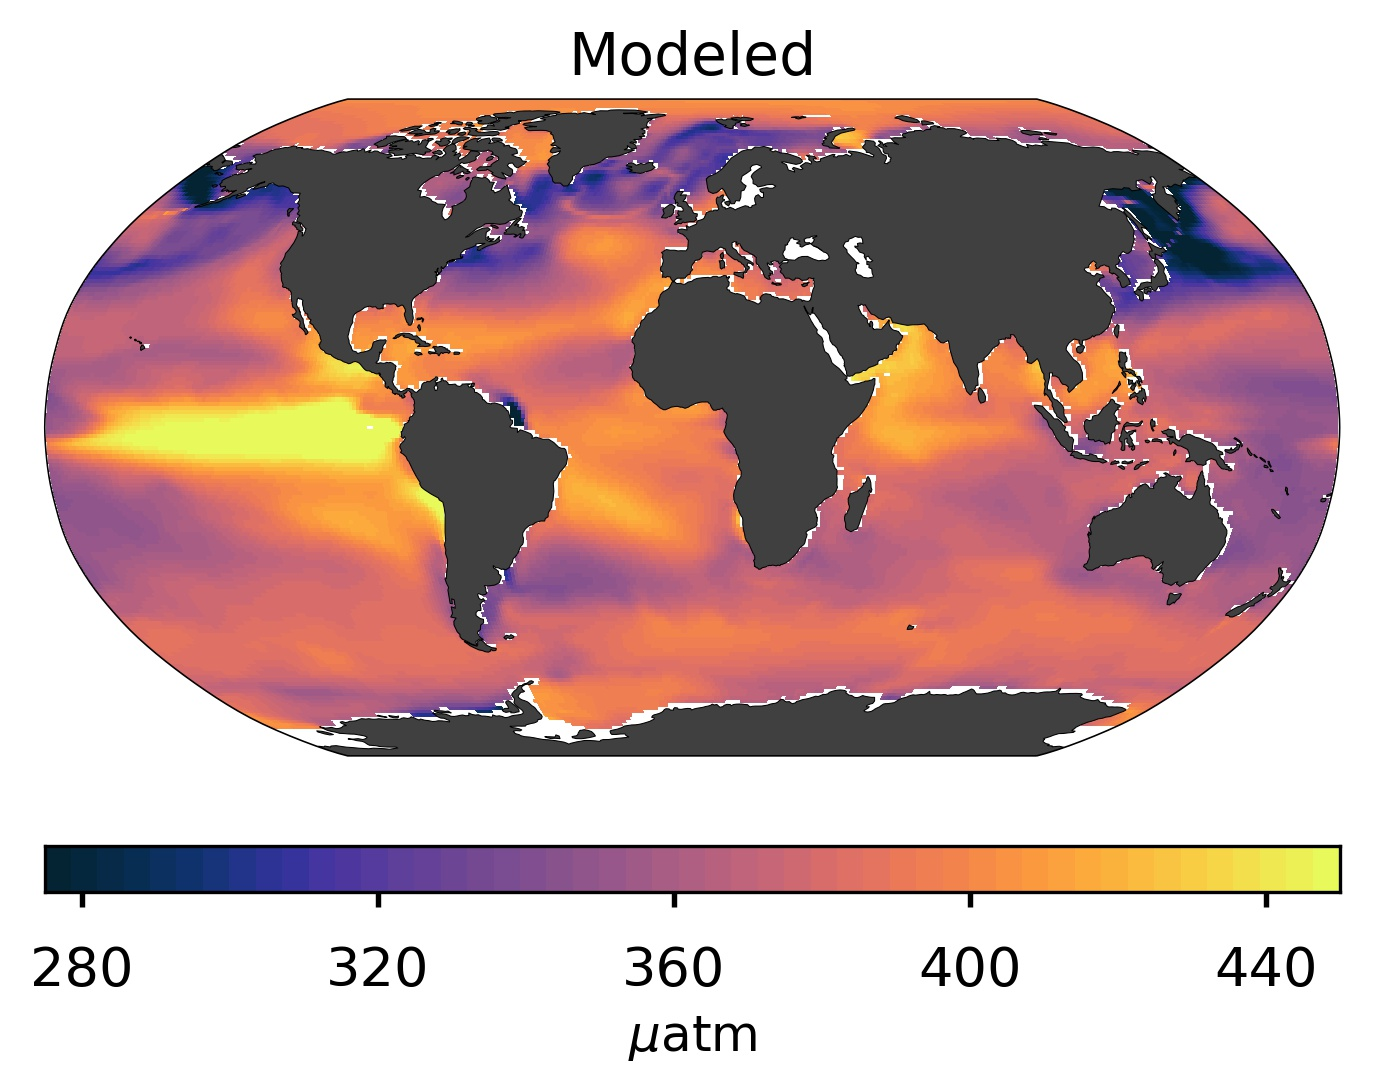

In [14]:
region='world'
cmap = cm.cm.thermal
plot_style = 'seaborn-talk'

fig = plt.figure(figsize=(6,3.5))
fig_shape=(1,1)
vrange = [275, 450, 50]
    
with plt.style.context(plot_style):
    dia = SpatialMap2(nrows_ncols=fig_shape, fig=fig, cbar_location='bottom', cbar_orientation='horizontal')
    data2 = test[f'cesm_sfco2_1x1_A'][400,:,:].transpose()
    sub=dia.add_plot(lat=test.lat,lon=test.lon,data=data2, vrange=vrange[0:3], cmap=cmap,ax=0)
    dia.set_title("Modeled",0,fontsize=14)
    col = dia.add_colorbar(sub)
    dia.set_cbar_xlabel(col,f"$\mu$atm",fontsize=12)
plt.show()

In [15]:
# Dates of Reconstruction 
date_range_start = '1959-01-01T00:00:00.000000000'
date_range_end = '2020-12-01T00:00:00.000000000'

# create date vector
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')

In [16]:
# Initialize array to include all model reconstructions...
# Since some values are NaN in some grid locations, we cannot just sum the pCO2s and divide by number of models
recon_array = np.empty(shape=(8,468,180,360)) # num models, months, lat, lon

In [17]:
m=0
for mod in models:
    
    print(mod)
    tmp = xr.load_dataset(f"{recon_output_dir}/{mod}_recon_198201-202012.nc")
    # Want pCO2 reconstruction, which is error + model
    # df['error'] =  df['pCO2'] - df[f"{mod}"]
    guess = (tmp[f"{mod}"] + tmp[f"error_{mod}"]).transpose("time","ylat","xlon")
    del tmp
    
    recon_array[m,:,:,:] = guess
    
    del guess
    m +=1 

cesm_sfco2_1x1_A
fesom2_sfco2_1x1_A
mpi_sfco2_1x1_A
cnrm_sfco2_1x1_A
ipsl_sfco2_1x1_A
planktom_sfco2_1x1_A
noresm_sfco2_1x1_A
princeton_sfco2_1x1_A


In [18]:
recon_pCO2 = np.nanmean(recon_array,axis=0)

/home/vbennington/.conda/envs/dev2/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


/home/vbennington/.conda/envs/dev2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


Text(0.5,1,'Recon Mean pCO2')

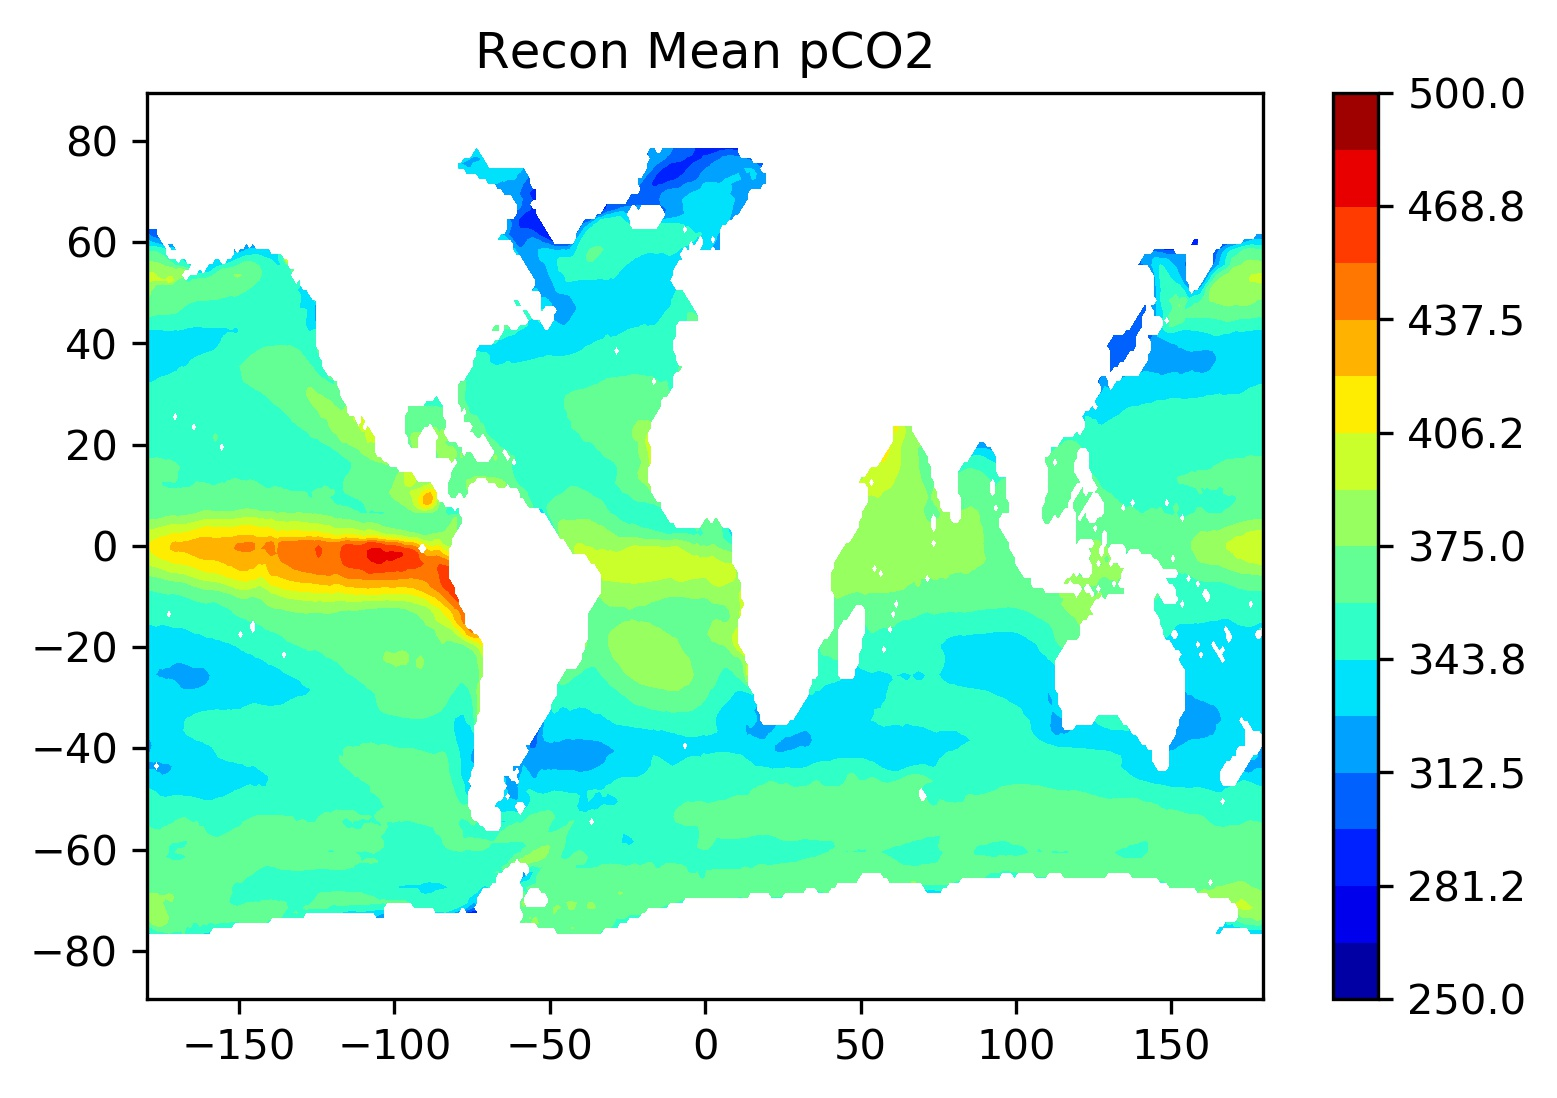

In [20]:
fig = plt.figure()
plt.contourf(test.lon,test.lat,np.nanmean(recon_pCO2,axis=0),cmap='jet',levels=np.linspace(250,500,17))
plt.colorbar()
plt.title("Recon Mean pCO2")

### Climatology of Corrections

In [21]:
clim_corr_1998_2020 = np.empty(shape=(8,12,180,360))  # 8 models, 12 months, 180 lat, 360 lon
clim_corr_1982_2020 = np.empty(shape=(8,12,180,360))
clim_corr_2000_2020 = np.empty(shape=(8,12,180,360))

In [22]:
# Get climatology of corrections #
##################################
m=0
for mod in models:
    
    print(mod)
    tmp = xr.load_dataset(f"{recon_output_dir}/{mod}_recon_198201-202012.nc")
    
    clim_corr_1998_2020[m,:,:,:]= tmp[f"error_{mod}"].transpose("time","ylat","xlon").sel(time=slice('1998-01-01','2020-12-31')).groupby("time.month").mean("time")
    clim_corr_1982_2020[m,:,:,:]= tmp[f"error_{mod}"].transpose("time","ylat","xlon").sel(time=slice('1982-01-01','2020-12-31')).groupby("time.month").mean("time")
    clim_corr_2000_2020[m,:,:,:]= tmp[f"error_{mod}"].transpose("time","ylat","xlon").sel(time=slice('2000-01-01','2020-12-31')).groupby("time.month").mean("time")

    del tmp
        
    m +=1 

cesm_sfco2_1x1_A
fesom2_sfco2_1x1_A
mpi_sfco2_1x1_A
cnrm_sfco2_1x1_A
ipsl_sfco2_1x1_A
planktom_sfco2_1x1_A
noresm_sfco2_1x1_A
princeton_sfco2_1x1_A


### Get pCO2 reconstructions prior to 1982 for each model

In [25]:
pCO2_cc_1998_2020 = np.empty(shape=(8,744,180,360))  # 8 models, 62 years, 180 lat, 360 lon
pCO2_cc_1982_2020 = np.empty(shape=(8,744,180,360))
pCO2_cc_2000_2020 = np.empty(shape=(8,744,180,360))

In [26]:
# Climatology Correction Entire Time:
pCO2_cc_1998_2020_all = np.empty(shape=(8,744,180,360))  # 8 models, 62 years, 180 lat, 360 lon
pCO2_cc_1982_2020_all = np.empty(shape=(8,744,180,360))
pCO2_cc_2000_2020_all = np.empty(shape=(8,744,180,360))

In [29]:
# Get model output from prior to 1982:
# Now we need the GCB models pCO2:
dm = xr.open_dataset('/data/artemis/simulations/GCB/2021models/gcb_load_A_2021_models.nc',decode_times=False)
dm = dm.rename({'X':'xlon','Y':'ylat','T':'time'})
dm['xlon'] = list(map(lambda x: x-360 if x>180 else x, dm['xlon'].values))
dm = dm.sortby('xlon')
dm['time']=pd.date_range(start=f'1958-01T00:00:00.000000000',end=f'2020-12T00:00:00.000000000',freq='MS') + np.timedelta64(14, 'D')
# IPSL is corrected:
#di = xr.open_dataset('/data/artemis/simulations/GCB/2020models/IPSL_corrected.nc',decode_times=False)
#di = di.rename({'months':'time',"lon":"xlon","lat":"ylat"})
#di['xlon'] = list(map(lambda x: x-360 if x>180 else x, di['xlon'].values))
#di = di.sortby('xlon')
#di['time']=pd.date_range(start=f'1958-01T00:00:00.000000000',end=f'2019-12T00:00:00.000000000',freq='MS') + np.timedelta64(14, 'D')
#dm['ipsl_spco2_1x1_A'] = di['IPSL_pco2_corrected'].transpose("time","ylat",'xlon')
#del di
print(dm)

<xarray.Dataset>
Dimensions:                (time: 756, xlon: 360, ylat: 180)
Coordinates:
  * xlon                   (xlon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * ylat                   (ylat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time                   (time) datetime64[ns] 1958-01-15 ... 2020-12-15
Data variables:
    area                   (ylat, xlon) float64 ...
    cesm_fgco2_1x1_A       (time, ylat, xlon) float64 ...
    cesm_sfco2_1x1_A       (time, ylat, xlon) float64 ...
    fesom2_fgco2_1x1_A     (time, ylat, xlon) float64 ...
    fesom2_sfco2_1x1_A     (time, ylat, xlon) float64 ...
    cnrm_fgco2_1x1_A       (time, ylat, xlon) float64 ...
    cnrm_sfco2_1x1_A       (time, ylat, xlon) float64 ...
    ipsl_fgco2_1x1_A       (time, ylat, xlon) float64 ...
    ipsl_sfco2_1x1_A       (time, ylat, xlon) float64 ...
    planktom_fgco2_1x1_A   (time, ylat, xlon) float64 ...
    planktom_sfco2_1x1_A   (time, ylat, xlon) float64 ...
    noresm_fgco2_1x1_A     (

In [30]:
##################################
m=0
for mod in models:
    
    print(mod)
    
    for yr in range(1959,1982):
        pCO2_cc_1998_2020[m,(yr-1959)*12:(yr-1958)*12,:,:] = clim_corr_1998_2020[m,:,:,:] + dm[f"{mod}"].sel(time=slice(f"{yr}-01-01",f"{yr}-12-31"))
        pCO2_cc_1982_2020[m,(yr-1959)*12:(yr-1958)*12,:,:] = clim_corr_1982_2020[m,:,:,:] + dm[f"{mod}"].sel(time=slice(f"{yr}-01-01",f"{yr}-12-31"))
        pCO2_cc_2000_2020[m,(yr-1959)*12:(yr-1958)*12,:,:] = clim_corr_2000_2020[m,:,:,:] + dm[f"{mod}"].sel(time=slice(f"{yr}-01-01",f"{yr}-12-31"))
        
    for yr in range(1959,2021):
        pCO2_cc_1998_2020_all[m,(yr-1959)*12:(yr-1958)*12,:,:] = clim_corr_1998_2020[m,:,:,:] + dm[f"{mod}"].sel(time=slice(f"{yr}-01-01",f"{yr}-12-31"))
        pCO2_cc_1982_2020_all[m,(yr-1959)*12:(yr-1958)*12,:,:] = clim_corr_1982_2020[m,:,:,:] + dm[f"{mod}"].sel(time=slice(f"{yr}-01-01",f"{yr}-12-31"))
        pCO2_cc_2000_2020_all[m,(yr-1959)*12:(yr-1958)*12,:,:] = clim_corr_2000_2020[m,:,:,:] + dm[f"{mod}"].sel(time=slice(f"{yr}-01-01",f"{yr}-12-31"))
    
    m +=1 

cesm_sfco2_1x1_A
fesom2_sfco2_1x1_A
mpi_sfco2_1x1_A
cnrm_sfco2_1x1_A
ipsl_sfco2_1x1_A
planktom_sfco2_1x1_A
noresm_sfco2_1x1_A
princeton_sfco2_1x1_A


In [31]:
#### Fill in 1982-2020 with LDEO-HPD results:
m = 0
for mod in models:
    print(mod)
    pCO2_cc_1998_2020[m,-468::,:,:] = recon_array[m,:,:,:]
    pCO2_cc_1982_2020[m,-468::,:,:] = recon_array[m,:,:,:]
    pCO2_cc_2000_2020[m,-468::,:,:] = recon_array[m,:,:,:]
    
    m+=1

cesm_sfco2_1x1_A
fesom2_sfco2_1x1_A
mpi_sfco2_1x1_A
cnrm_sfco2_1x1_A
ipsl_sfco2_1x1_A
planktom_sfco2_1x1_A
noresm_sfco2_1x1_A
princeton_sfco2_1x1_A


In [33]:
# Create DataSets and Write out NETCDFs for Reconstructed pCO2:

ds_out = xr.Dataset({
                        'pCO2':(["model","time","lat","lon"],pCO2_cc_1998_2020),
                        'pCO2cc':(["model","time","lat","lon"],pCO2_cc_1998_2020_all),
                        'correction':(["model","month","lat","lon"],clim_corr_1998_2020)},
                        coords={'model':(['model'],models),
                        'month':(['month'],range(1,13)),
                        'time': (['time'],dates),
                        'lat': (['lat'],test.lat),
                        'lon':(['lon'],test.lon)})
        
# Save to netcdf
ds_out['pCO2'].attrs['description'] = "Climatology of correction (1998-2020) used for pCO2 prior to 1982"
ds_out['pCO2'].attrs['units'] = "uatm"
ds_out['pCO2cc'].attrs['description'] = "Climatology of correction (1998-2020) used for pCO2 ENTIRE TIME"
ds_out['pCO2cc'].attrs['units'] = "uatm"
ds_out['correction'].attrs['description'] = "Climatology of correction (1998-2020) used for pCO2 (pCO2 = correction + model)"
ds_out['correction'].attrs['units'] = "uatm"
ds_out.attrs['title']="LDEO-HPD Clim Correct 1998-2020"
ds_out.attrs['history']="XGBoost results and Clim Corrections by Val Bennington"
ds_out.attrs['institution']="Lamont Doherty Earth Observatory at Columbia"
ds_out.attrs['references']="/home/vbennington/LDEO_HPD/model_output_processing/recon_pCO2_CO2flux.ipynb"
ds_out.attrs['date_created']=str(datetime.datetime.now())
ds_out.to_netcdf(f'{recon_output_dir}/pCO2_cc1998-2020_1x1_recon_1959-2020.nc') 

#################################################################################################################
ds2_out = xr.Dataset({
                        'pCO2':(["model","time","lat","lon"],pCO2_cc_1982_2020),
                        'pCO2cc':(["model","time","lat","lon"],pCO2_cc_1982_2020_all),
                        'correction':(["model","month","lat","lon"],clim_corr_1982_2020)},
                        coords={'model':(['model'],models),
                        'month':(['month'],range(1,13)),
                        'time': (['time'],dates),
                        'lat': (['lat'],test.lat),
                        'lon':(['lon'],test.lon)})
        
# Save to netcdf
ds2_out['pCO2'].attrs['description'] = "Climatology of correction (1982-2020) used for pCO2 prior to 1982"
ds2_out['pCO2'].attrs['units'] = "uatm"
ds2_out['pCO2cc'].attrs['description'] = "Climatology of correction (1982-2020) used for pCO2 ENTIRE TIME"
ds2_out['pCO2cc'].attrs['units'] = "uatm"
ds2_out['correction'].attrs['description'] = "Climatology of correction (1982-2020) used for pCO2 (pCO2 = correction + model)"
ds2_out['correction'].attrs['units'] = "uatm"
ds2_out.attrs['title']="LDEO-HPD Clim Correct 1982-2020"
ds2_out.attrs['history']="XGBoost results and Clim Corrections by Val Bennington"
ds2_out.attrs['institution']="Lamont Doherty Earth Observatory at Columbia"
ds2_out.attrs['references']="/home/vbennington/LDEO_HPD/model_output_processing/recon_pCO2_CO2flux.ipynb"
ds2_out.attrs['date_created']=str(datetime.datetime.now())
ds2_out.to_netcdf(f'{recon_output_dir}/pCO2_cc1982-2020_1x1_recon_1959-2020.nc') 

#################################################################################################################
ds3_out = xr.Dataset({
                        'pCO2':(["model","time","lat","lon"],pCO2_cc_2000_2020),
                        'pCO2cc':(["model","time","lat","lon"],pCO2_cc_2000_2020_all),
                        'correction':(["model","month","lat","lon"],clim_corr_2000_2020)},
                        coords={'model':(['model'],models),
                        'month':(['month'],range(1,13)),
                        'time': (['time'],dates),
                        'lat': (['lat'],test.lat),
                        'lon':(['lon'],test.lon)})
        
# Save to netcdf
ds3_out['pCO2'].attrs['description'] = "Climatology of correction (2000-2020) used for pCO2 prior to 1982"
ds3_out['pCO2'].attrs['units'] = "uatm"
ds3_out['pCO2cc'].attrs['description'] = "Climatology of correction (2000-2020) used for pCO2 ENTIRE TIME"
ds3_out['pCO2cc'].attrs['units'] = "uatm"
ds3_out['correction'].attrs['description'] = "Climatology of correction (2000-2020) used for pCO2 (pCO2 = correction + model)"
ds3_out['correction'].attrs['units'] = "uatm"
ds3_out.attrs['title']="LDEO-HPD Clim Correct 2000-2020"
ds3_out.attrs['history']="XGBoost results and Clim Corrections by Val Bennington"
ds3_out.attrs['institution']="Lamont Doherty Earth Observatory at Columbia"
ds3_out.attrs['references']="/home/vbennington/LDEO_HPD/model_output_processing/recon_pCO2_CO2flux.ipynb"
ds3_out.attrs['date_created']=str(datetime.datetime.now())
ds3_out.to_netcdf(f'{recon_output_dir}/pCO2_cc2000-2020_1x1_recon_1959-2020.nc') 

### Get CO2 flux from reconstructed LDEO-HPD reconstructed pCO2

In [46]:
# Use mean pCO2 from the 9 models and then calculate flux:

In [34]:
cc_1982_2020 = ds2_out.pCO2.mean("model")
cc_2000_2020 = ds3_out.pCO2.mean("model")
cc_1998_2020 = ds_out.pCO2.mean("model")

cclim_1982_2020 = ds2_out.pCO2cc.mean("model")
cclim_2000_2020 = ds3_out.pCO2cc.mean("model")
cclim_1998_2020 = ds_out.pCO2cc.mean("model")

/home/vbennington/.conda/envs/dev2/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/vbennington/.conda/envs/dev2/lib/python3.6/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


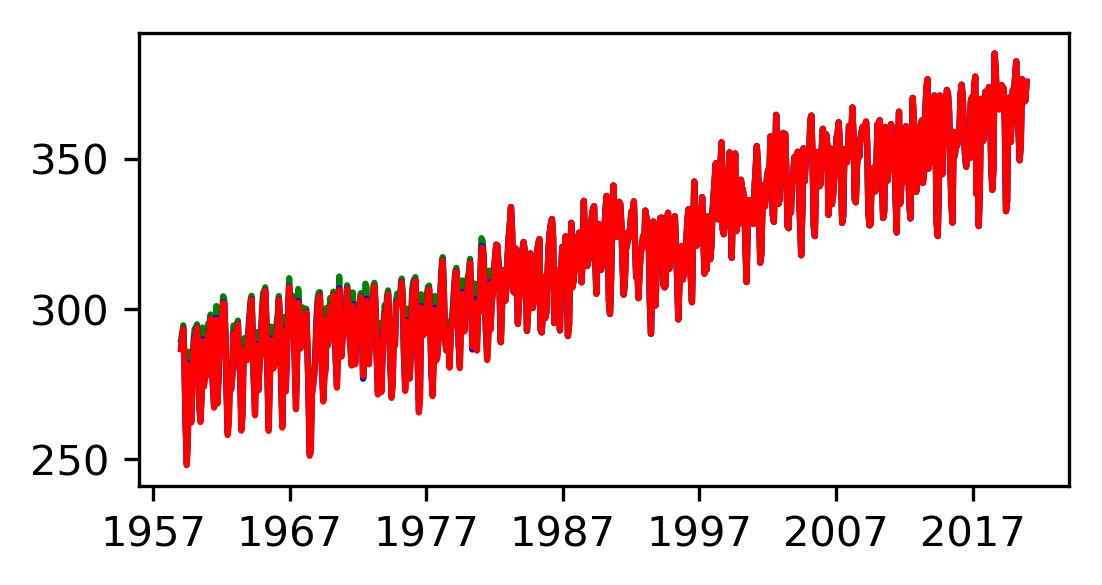

In [35]:
fig = plt.figure(figsize=(4,2))
plt.plot(dates,cc_1982_2020[:,135,140],'green')
plt.plot(dates,cc_1998_2020[:,135,140],'blue')
plt.plot(dates,cc_2000_2020[:,135,140],'red')

## Load Atmospheric Conditions Needed

In [36]:
k_ds = xr.open_dataset('/data/artemis/workspace/vbennington/LDEO_HPD/data_for_flux/ERA5_K0_kw_atmos_pco2_1959-2020.nc')
#k_ds = xr.open_dataset("/data/artemis/workspace/vbennington/LDEO_HPD/data_for_flux/NOAA_ERSST_K0_kw_atmos_pco2_1959-2019.nc")
kw = k_ds.kw * (24/100)  #cm/hr --> m/day
K0 = k_ds.K0/1000 # mmol / m3 / atm  --> mol/m3/uatm
mC = 12.0108 # g / mol
pCO2air = k_ds.carbo_scope_pco2 # micro atmospheres
icef = k_ds.ice
coast=xr.open_dataset('/data/artemis/workspace/vbennington/LDEO_HPD/data_for_flux/coastal_scaled_spCO2_fromHPD_1959-2020.nc')

# Only look at open ocean:
mask = xr.open_dataset('/data/artemis/observations/SOCOM/extra_files/RECCAP2_region_masks_all.nc') 
#replace longitude from 0-360 to -180 to 180
mask['lon'] = list(map(lambda x: x-360 if x>180 else x, mask['lon'].values))
# Sort by longitude
mask = mask.sortby('lon')

fk = xr.open_dataset('/data/artemis/observations/SOCOM/extra_files/FluxKit_calculation_1982-2019_v20201120.nc')

#### Flux Calculations

2000-2020
1998-2020
1982-2020


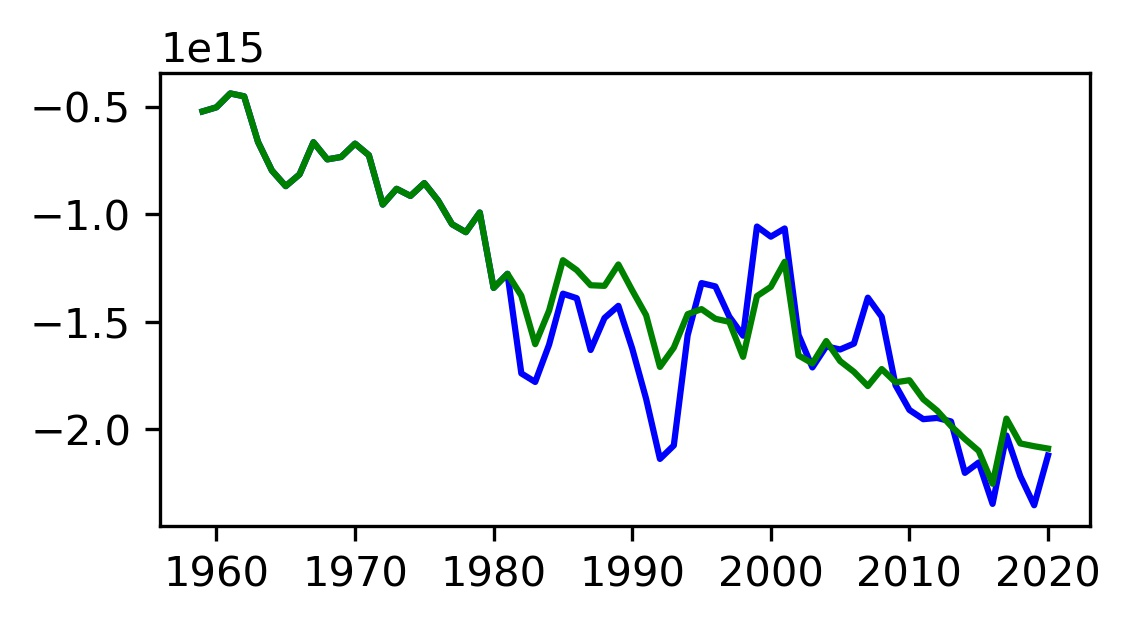

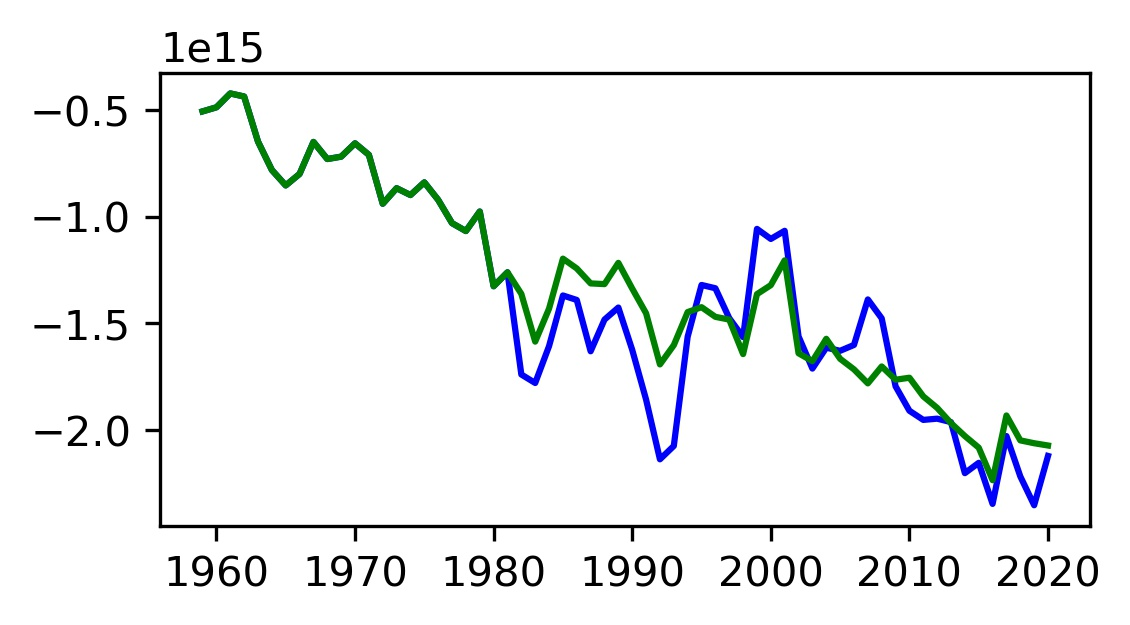

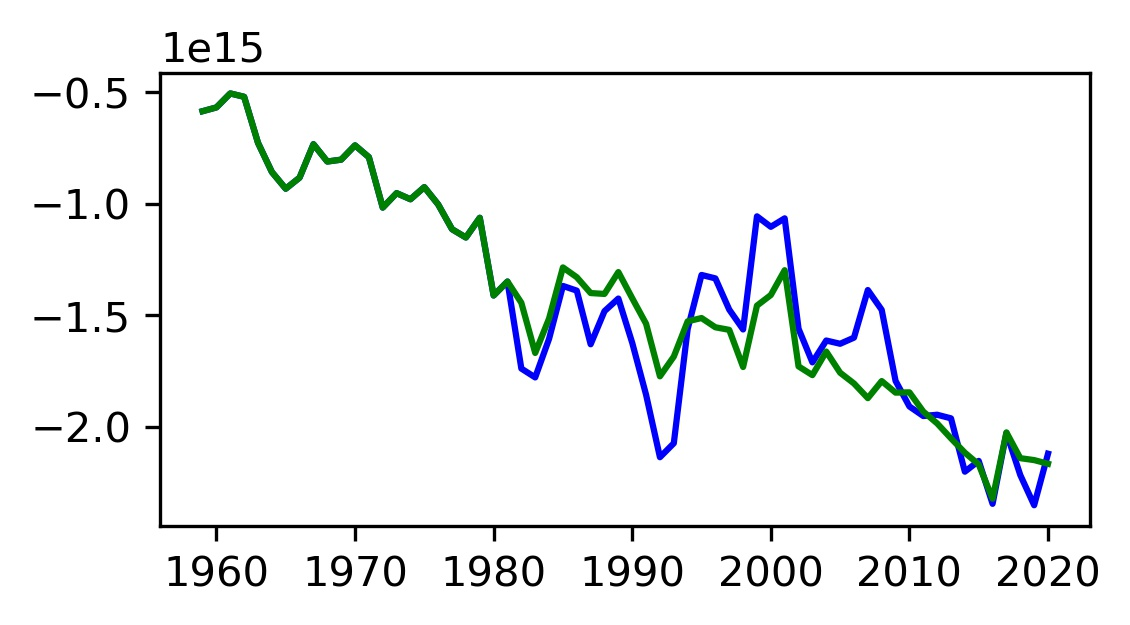

In [38]:
for correction in ['2000-2020','1998-2020','1982-2020']:
    
    print(correction)
    
    # Load pCO2 and get mean across models:
    tmp_ds = xr.load_dataset(f'{recon_output_dir}/pCO2_cc{correction}_1x1_recon_1959-2020.nc')

    hpd = tmp_ds['pCO2'].mean("model").sel(time=slice("01-01-1959","12-31-2020")).fillna(coast.spco2_scale_clim)
    hpdclim = tmp_ds['pCO2cc'].mean("model").sel(time=slice("01-01-1959","12-31-2020")).fillna(coast.spco2_scale_clim)
    #  (m/day)*(mmol/m3/atm)*(atm)*(g/mmol) = (g/m2/day)
    co2 = kw * K0 * (hpd - pCO2air) * (1-icef) * mC * 365 # g / m2 / year
    co2_clim = kw * K0 * (hpdclim - pCO2air) * (1-icef) * mC * 365 # g / m2 / year
    
    flux_region = (co2.where(mask['open_ocean']>=1)*(fk.area)).sum(['lat','lon'])
    flux_region_hpdclim = (co2_clim.where(mask['open_ocean']>=1)*(fk.area)).sum(['lat','lon'])

    # Integrate the flux #
    ######################
    flux_hpd = flux_region.groupby("time.year").mean("time")
    flux_hpdclim = flux_region_hpdclim.groupby("time.year").mean("time")
    
    # Plot this up and write to file:
    fig = plt.figure(figsize=(4,2))
    plt.plot(range(1959,2021),flux_hpd,'blue')
    plt.plot(range(1959,2021),flux_hpdclim,'green')
    
    # Write to file:
    co2_out = xr.Dataset({
                        'CO2':(["year"],flux_hpd/(10**15)),
                        'CO2cc':(["year"],flux_hpdclim/(10**15)),
                        'fgco2':(["time","lat","lon"],co2),
                        'fgco2_cc':(["time","lat","lon"],co2_clim)},
                        coords={'year':(['year'],range(1959,2021)),
                               'time':(['time'],tmp_ds.time),
                               'lat':(['lat'],tmp_ds.lat),
                               'lon':(['lon'],tmp_ds.lon)})
        
    # Save to netcdf
    co2_out['CO2'].attrs['description'] = f"CO2 Flux, Climatology of correction ({correction}) used for pCO2 prior to 1982"
    co2_out['CO2'].attrs['units'] = "PgC/yr"
    co2_out['CO2cc'].attrs['description'] = "CO2 Flux, Climatology of correction used for pCO2 ENTIRE TIME"
    co2_out['CO2cc'].attrs['units'] = "PgC/yr"
    co2_out['fgco2'].attrs['description'] = f"CO2 Flux, Climatology of correction ({correction}) used for pCO2 prior to 1982"
    co2_out['fgco2'].attrs['units'] = "gC/m2/yr"
    co2_out['fgco2_cc'].attrs['description'] = "CO2 Flux, Climatology of correction used for pCO2 ENTIRE TIME"
    co2_out['fgco2_cc'].attrs['units'] = "gC/m2/yr"
    co2_out.attrs['title']=f"LDEO-HPD Clim Correct {correction}"
    co2_out.attrs['history']="XGBoost results and Clim Corrections by Val Bennington"
    co2_out.attrs['institution']="Lamont Doherty Earth Observatory at Columbia"
    co2_out.attrs['references']="/home/vbennington/LDEO_HPD/model_output_processing/recon_pCO2_CO2flux.ipynb"
    co2_out.attrs['date_created']=str(datetime.datetime.now())
    co2_out.to_netcdf(f'{recon_output_dir}/CO2flux_cc{correction}_1x1_recon_1959-2020.nc') 
    
    del co2_out